In [1]:
import platform
platform.python_version()

'3.7.11'

In [2]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import circularMask
from pepe.simulate import genSyntheticResponse

# Compare against Olivier's code
sys.path.append('/home/jack/workspaces/jupyter-workspace/pegs_py')
import StressEngineC.StressEngineC as SEC

# Compare against Jonathan's code
import matlab.engine
import matlab
eng = matlab.engine.start_matlab()
sys.path.append('/home/jack/workspaces/matlab-workspace/PEGS/')
import numpy as np

import numba
from PIL import Image

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

# For timing
import time

In [66]:
@numba.jit(nopython=True)
def stressEngine(yInd, xInd, forceArr, alphaArr, betaArr, fSigma, radius, brightfield, pxPerMeter):
    # We expect that distance/position values are NOT in physical units yet
    # so we have to divide by pxPerMeter to get real values
    xM = xInd/pxPerMeter
    yM = yInd/pxPerMeter
    radiusM = radius/pxPerMeter

    # Coordination number
    z = len(forceArr)
    
    # Iterate over each force, and calculate the total stress
    # attributed to that force (at the given point)
    sigmaXX, sigmaXY, sigmaYY = 0,0,0
    for i in range(z):
        # Adjust beta for rotation to match the real images we are working with
        b1 = -betaArr[i] + np.pi
        # The middle expression is really just the sign function, but we
        # need sign(0)=1 (sign(0)=0 by default) so we do a little
        # boolean magic
        b2 = b1 - (2 - int(np.sign(alphaArr[i]) > -1)) *np.pi + 2*alphaArr[i]
                        
        # Calculate the length of the chord
        chordX = radiusM * (np.sin(b2) - np.sin(b1))
        chordY = radiusM * (np.cos(b2) - np.cos(b1))
        chordLength = np.sqrt(chordX**2 + chordY**2)
                        
        # Calculate the vector for the given position to the chord
        vecX = xM - radiusM*np.sin(b1)
        vecY = -yM - radiusM*np.cos(b1) # Not sure why there is negative here
        rVec = np.sqrt(vecX**2 + vecY**2)
        
        # Error check
        # See if either the vector or the chord length is zero
        if rVec*chordLength == 0:
            #print("Bad length")
            return 0
        
        # Normalize the components of the chord
        chordX /= chordLength
        chordY /= chordLength
        
        arccosArgument = (vecX*chordX + vecY*chordY) / rVec

        th = np.sign(vecY*chordX - vecX*chordY) * np.arccos(arccosArgument)
        
        s1 = -2/np.pi * forceArr[i]*arccosArgument / rVec
        s2 = -1/(np.pi*radiusM) * forceArr[i] * (-np.sin(alphaArr[i]))
        sr = s1 - s2
        
        th += betaArr[i] - np.pi/2 - alphaArr[i]
        
        sigmaXX += sr*np.sin(th)**2
        sigmaYY += sr*np.cos(th)**2
        sigmaXY += 0.5*s1*np.sin(2*th)
        
    pressureDiff = sigmaXX - sigmaYY
    totalStress = np.sqrt(pressureDiff**2 + 4*sigmaXY**2)
    
    # Brightfield vs darkfield we use cos vs sin
    if brightfield:
        return np.cos(np.pi/fSigma * totalStress)**2
    else:
        return np.sin(np.pi/fSigma * totalStress)**2

In [19]:
# Create a fake particle
radius = 200

imageShape = np.array([500, 500])
center = imageShape/2

cMask = circularMask(imageShape, center, radius)[:,:,0]

# Find all points inside the particle (on the grid)
gridPoints = np.transpose(np.where(cMask > 0))
# And relative to the center of the particle
particlePoints = gridPoints - center

# Setup physical parameters
# We have to be very careful about types, since Olivier's method is written
# in native C and compiled with Cython, which does not have the best
# type-conversion interface (especially compared to numba :) )
fSigma = 10.
pxPerMeter = 1000.
brightfield = int(False)

forceArr = np.array([1, 1], dtype=np.double) # [N]
betaArr = np.array([0, -np.pi], dtype=np.double) # [rad]
alphaArr = np.array([0, 0], dtype=np.double) # [rad]

mForceArr = matlab.double([1, 1]) # [N]
mBetaArr = matlab.double([0., -np.pi]) # [rad]
mAlphaArr = matlab.double([0., 0.]) # [rad]


z = len(forceArr)

Jack's finished in: 0.04389984299996286 seconds
Olivier's finished in: 0.20971973999985494 seconds
Jonathan's finished in: 0.5387369390009553 seconds


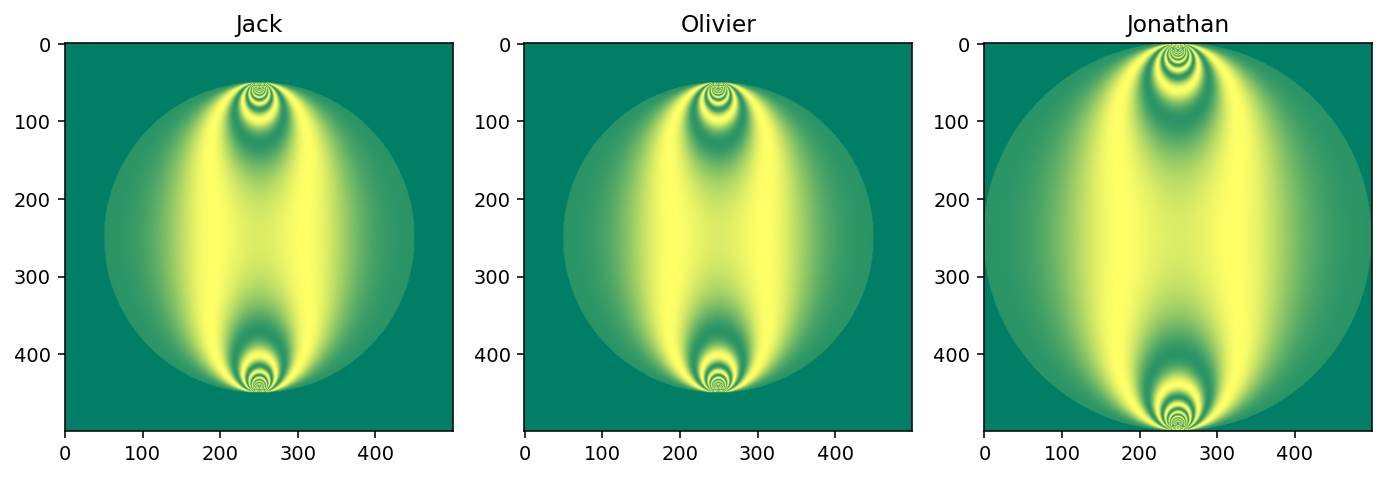

In [23]:
intensityArr = np.zeros([3, imageShape[0], imageShape[1]], dtype=np.float64)

startTime = time.perf_counter()
intensityArr[0] = genSyntheticResponse(forceArr, alphaArr, betaArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape)
#for i in range(len(gridPoints)):
#    intensityArr[0,gridPoints[i,0],gridPoints[i,1]] = stressEngine(particlePoints[i,0], particlePoints[i,1], forceArr, alphaArr, betaArr, fSigma, radius, brightfield, pxPerMeter)
print(f'Jack\'s finished in: {time.perf_counter() - startTime} seconds')
    
startTime = time.perf_counter()
for i in range(len(gridPoints)):
    intensityArr[1,gridPoints[i,0],gridPoints[i,1]] = SEC.StressEngineC(particlePoints[i,1]/pxPerMeter, particlePoints[i,0]/pxPerMeter, z, forceArr, alphaArr, betaArr, fSigma, radius/pxPerMeter, brightfield)
print(f'Olivier\'s finished in: {time.perf_counter() - startTime} seconds')

startTime = time.perf_counter()
# Note the transpose, since we want to flip the format to be [y,x] instead of [x,y]
intensityArr[2] = np.transpose(eng.joForceFunc(z, mForceArr, mAlphaArr, mBetaArr, fSigma, radius/pxPerMeter, int(imageShape[0]), 1))
print(f'Jonathan\'s finished in: {time.perf_counter() - startTime} seconds')

    
intensityArr[intensityArr == 0] = -.2
fig, ax = plt.subplots(1, 3, figsize=(10,4))

for i in range(3):
    ax[i].imshow(intensityArr[i], cmap=plt.get_cmap('summer'))
    
ax[0].set_title('Jack')
ax[1].set_title('Olivier')
ax[2].set_title('Jonathan')

fig.tight_layout()
plt.show()

In [24]:
np.subtract.outer(np.sum(intensityArr, axis=(-1, -2)), np.sum(intensityArr, axis=(-1, -2)))

array([[     0.        ,      0.        , -47284.48894413],
       [     0.        ,      0.        , -47284.48894413],
       [ 47284.48894413,  47284.48894413,      0.        ]])

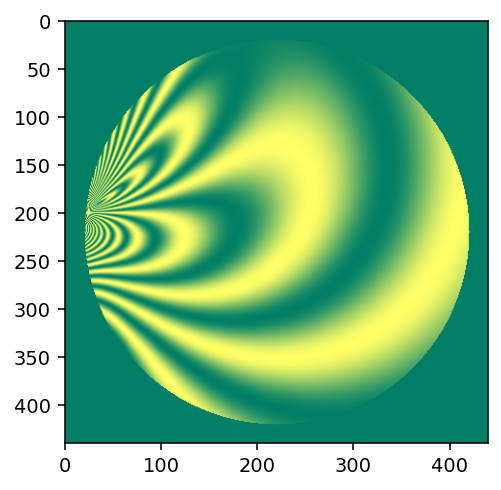

In [6]:
intensityArr = genSyntheticResponse(forceArr, alphaArr, betaArr, fSigma, radius, pxPerMeter)
plt.imshow(intensityArr, cmap=plt.get_cmap('summer'))
plt.show()

In [23]:
radius = 240
imageSize = np.array([500, 500])
steps = 2000
fps = 60

images = [[] for i in range(steps)]

for i in range(steps):
    f = np.array([.05, .05]) * i
    a = np.array([0., 0.])
    b = np.array([0., -np.pi])
    imageArr = np.zeros((imageSize[0], imageSize[1], 3), dtype=np.uint8)
    imageArr[:,:,0] = np.uint8(255*genSyntheticResponse(f, a, b, fSigma, radius, pxPerMeter, imageSize=imageSize))
    images[i] = Image.fromarray(imageArr)
    
images[0].save('calibration.gif', save_all=True, append_images=images[1:], duration=fps, optimize=True, loop=1)